In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import math
from skimage import img_as_bool
from matplotlib.pylab import imshow, imsave
from skimage.filters import frangi
from matplotlib import pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes
from process_image import process_image
from ipyregulartable import RegularTableWidget as table
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from prepare_image import prepare_image
from joblib import dump, load
from IPython.display import display
from imblearn.metrics import sensitivity_specificity_support


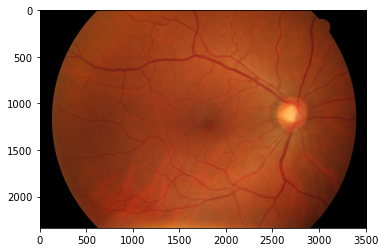

In [49]:
image = cv.imread('data/all/images/15_h.JPG')
imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
#imsave('report/processing/input_image.png', cv.cvtColor(image, cv.COLOR_BGR2RGB))

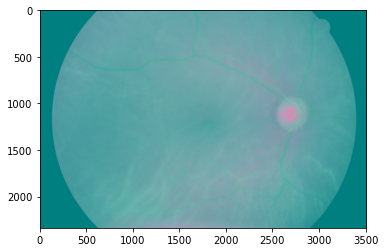

In [50]:
# convert to CIELAB color space and extract lightness
image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
imshow(image_lab)
#imsave('report/processing/lab_image.png', image_lab, cmap='gray')
l, a, b = cv.split(image_lab)


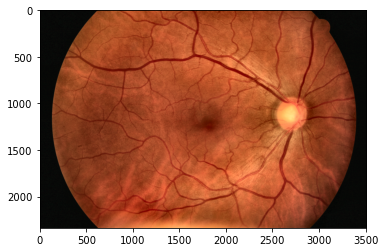

In [51]:
# apply contrast limited adaptive histogram equalization to the L channel
# https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
clahe = cv.createCLAHE(clipLimit = 3.0)
merged = cv.merge((clahe.apply(l), a, b))
merged = cv.cvtColor(merged, cv.COLOR_LAB2RGB)
# imshow(clahe.apply(l))
imshow(merged)
#imsave('report/processing/clahe_image.png', merged, cmap='gray')


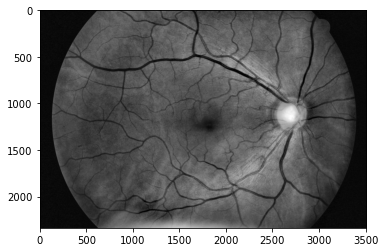

In [52]:
# convert image to BGR and extract green channel (vessels' visibility is the best)
r, g, b = cv.split(merged)
#imsave('report/processing/green_image.png', g, cmap='gray')
imshow(g, cmap = 'gray')

In [53]:
image_frangi = frangi(g)

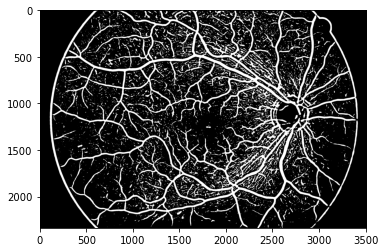

In [54]:
#imsave('report/processing/frangi_image.png', image_frangi, cmap='gray')
ret, thresh = cv.threshold(image_frangi,
                           np.mean(image_frangi) * 0.45, 255, cv.THRESH_BINARY)  #for healthy eyes *0.4 bc of thin tips
thresh = thresh.astype('uint8')
imshow(thresh, cmap = 'gray')
#imsave('report/processing/thresh_image.png', thresh, cmap='gray')



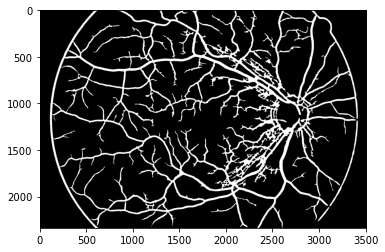

In [55]:
deblobed = thresh > 0
deblobed = remove_small_objects(deblobed, 2500, connectivity = 1)
deblobed = remove_small_holes(deblobed, 900, connectivity = 1)
deblobed = deblobed.astype('uint8') * 255
# (6,6) gives ca 96-98% accuracy and specificity
deblobed = cv.erode(deblobed, cv.getStructuringElement(cv.MORPH_ELLIPSE, (1, 1)))
deblobed = cv.morphologyEx(deblobed, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (12, 12)))
imshow(deblobed, cmap = 'gray')
#imsave('report/processing/deblobed_image.png', deblobed, cmap='gray')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


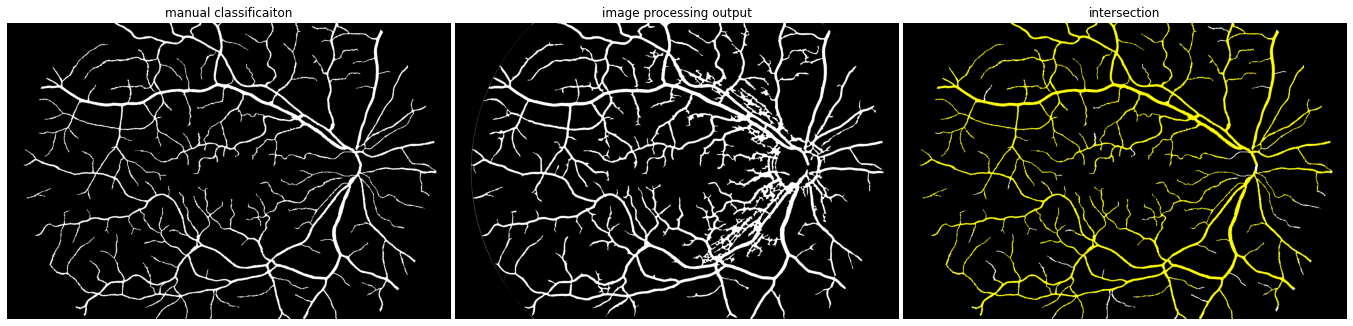

In [56]:
# load the hand-made mask
mask = cv.imread('data/all/manual1/15_h.tif', cv.IMREAD_GRAYSCALE)
cut = cv.imread('data/all/mask/15_h_mask.tif', cv.IMREAD_GRAYSCALE)
cut = cv.bitwise_and(cut, deblobed)

predicted = (cut == 255)
truth = (mask == 255)
true_positive = (predicted & truth)

yellow_mask = np.zeros((*cut.shape, 3))
yellow_mask[truth, :] = 255
yellow_mask[true_positive] = [127, 127, 0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.01, hspace=0.1)
fig.set_size_inches(24, 18)
ax1.imshow(mask, cmap = 'gray')
ax1.set_title('manual classificaiton')
ax2.imshow(cut, cmap = 'gray')
ax2.set_title('image processing output')
ax3.imshow(yellow_mask)
ax3.set_title('intersection')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
fig.savefig('report/processing/15_h.png')

In [57]:
processed = cut
image_size = processed.shape[0] * processed.shape[1]

mask_binary = mask.copy()
mask_binary[mask_binary < 127] = 0
mask_binary[mask_binary >= 127] = 1

processed_binary = processed.copy()
processed_binary[processed_binary < 127] = 0
processed_binary[processed_binary >= 127] = 1

#TN, FP, FN, TP = confusion_matrix(mask_binary.flatten(), processed_binary.flatten()).ravel()
TP = np.sum(processed_binary[mask_binary == 1])
FP = np.sum(processed_binary[mask_binary == 0])
FN = np.sum(mask_binary[mask_binary == 1]) - np.sum(processed_binary[mask_binary == 1])
TN = image_size - np.sum(processed_binary[mask_binary == 0]) - TP - FN
print(f'TN', TN)
print(f'FP', FP)
print(f'FN', FN)
print(f'TP', TP)


TN 7096160
FP 447939
FN 47567
TP 593678


In [58]:
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)


accuracy: 0.9394642424313505
sensitivity :  0.9258208641003048
specificity:  0.9406239234135183


In [2]:
accuracies = []
sensitivities = []
specificities = []
weighted_sensitivities = []
weighted_specificities = []

for i in range(1, 15):
    image = cv.imread('data/all/images/' + str(i).zfill(2) + '_h.JPG')
    manual = cv.imread('data/all/manual1/' + str(i).zfill(2) + '_h.tif', cv.IMREAD_GRAYSCALE)
    mask = cv.imread('data/all/mask/' + str(i).zfill(2) + '_h_mask.tif', cv.IMREAD_GRAYSCALE)
    TN, FP, FN, TP, sen, spe = process_image(image, manual, mask)

    accuracy = (TP + TN) / (TP + FP + FN + TN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    weighted_sensitivities.append(sen)
    weighted_specificities.append(spe)


## Image processing outcome

In [3]:
geometric_means = []
geometric_means = np.sqrt(np.multiply(specificities, specificities))
data = [accuracies, sensitivities, specificities, geometric_means, weighted_sensitivities, weighted_specificities]
data = pd.DataFrame(data, index = ['accuracy', 'sensitivity', 'specificity', 'G-mean', 'w_sensitivity', 'w_specificity']).transpose()
data.loc['mean values'] = data.mean()
data.to_csv('image_processing.csv')
dt = table(data)
display(dt)

RegularTableWidget()

## Machine learning - k Nearest Neighbours Classifier

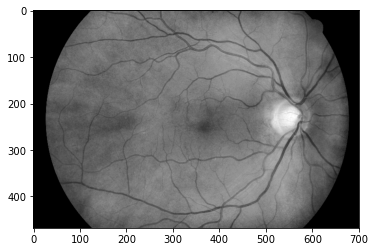

In [17]:
image = cv.imread('data/all/images/07_h.JPG')
mask = cv.imread('data/all/manual1/07_h.tif')
cut = cv.imread('data/all/mask/07_h_mask.tif', cv.IMREAD_GRAYSCALE)

image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
l, a, b = cv.split(image_lab)
clahe = cv.createCLAHE(clipLimit = 2.0)
merged = cv.merge((clahe.apply(l), a, b))
merged = cv.cvtColor(merged, cv.COLOR_LAB2RGB)
merged = cv.cvtColor(merged, cv.COLOR_RGB2GRAY)
tile_size = 5
merged = cv.bitwise_and(merged, cut)

merged = cv.copyMakeBorder(merged,
                           tile_size - merged.shape[0] % tile_size,
                           0,
                           tile_size - merged.shape[1] % tile_size,
                           0,
                           cv.BORDER_CONSTANT,
                           value = [0, 0, 0])

mask = cv.copyMakeBorder(mask,
                         tile_size - mask.shape[0] % tile_size,
                         0,
                         tile_size - mask.shape[1] % tile_size,
                         0,
                         cv.BORDER_CONSTANT,
                         value = [0, 0, 0])

merged = cv.resize(merged, (0, 0), fx = 0.2, fy = 0.2)
mask = cv.resize(mask, (0, 0), fx = 0.2, fy = 0.2)

imshow(merged, cmap = 'gray')


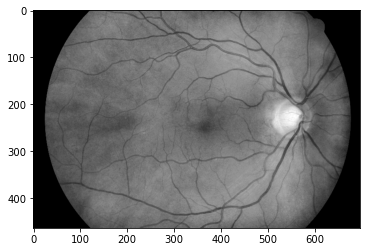

In [18]:
strides = merged.strides * 2
merged_shape = [merged.shape[0] - tile_size + 1, merged.shape[1] - tile_size + 1, tile_size, tile_size]
data = np.lib.stride_tricks.as_strided(merged, shape = merged_shape, strides = strides)
mask = np.lib.stride_tricks.as_strided(mask, shape = merged_shape, strides = strides)
mask = data.reshape(-1, tile_size, tile_size)
data = data.reshape(-1, tile_size, tile_size)
r = np.zeros((data.shape[0]))

for i in range(data.shape[0]):
    r[i] = data[i][2][2]

r = r.reshape((464, 697))
imshow(r, cmap = 'gray')


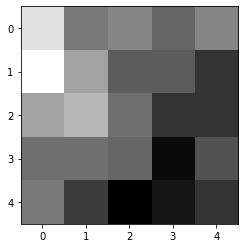

In [19]:
imshow(data[177000], cmap = 'gray')
moments_0 = np.zeros((data.shape[0]))
moments_1 = np.zeros((data.shape[0]))
moments_2 = np.zeros((data.shape[0]))
moments_3 = np.zeros((data.shape[0]))
moments_4 = np.zeros((data.shape[0]))
moments_5 = np.zeros((data.shape[0]))
moments_6 = np.zeros((data.shape[0]))
for i in range(0, data.shape[0], 10):
    m = cv.moments(data[i])
    moments_0[i] = cv.HuMoments(m)[0]
    moments_1[i] = cv.HuMoments(m)[1]
    moments_2[i] = cv.HuMoments(m)[2]
    moments_3[i] = cv.HuMoments(m)[3]
    moments_4[i] = cv.HuMoments(m)[4]
    moments_5[i] = cv.HuMoments(m)[5]
    moments_6[i] = cv.HuMoments(m)[6]


In [20]:
means = np.mean(data, axis = (1, 2))
_vars = np.var(data, axis = (1, 2))


In [21]:
truth = np.zeros((mask.shape[0]), dtype = 'uint8')
tile_coords = np.zeros((mask.shape[0], 2))
for i in range(mask.shape[0]):
    truth[i] = 1 if mask[i][tile_size // 2][tile_size // 2] > 127 else 0


In [22]:
data = [
    means.flatten(),
    _vars.flatten(),
    moments_0.flatten(),
    moments_1.flatten(),
    moments_2.flatten(),
    moments_3.flatten(),
    moments_4.flatten(),
    truth.flatten()
]
knn_data_frame = pd.DataFrame(
    data, index = ['mean', 'var', 'moment 0', 'moment 1', 'moment 2', 'moment 3', 'moment 4', 'truth']).transpose()
knn_data_frame = knn_data_frame[knn_data_frame['mean'] > 0]
dt = table(knn_data_frame)
display(dt)

RegularTableWidget()

In [84]:
X = knn_data_frame.iloc[:, 0:7]
y = knn_data_frame.iloc[:, 7]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
kNN = KNeighborsClassifier(n_neighbors = 3, p = 2, metric = 'euclidean')
kNN.fit(X_train, y_train)
dump(kNN, 'kNN_classifier.joblib')


['kNN_classifier.joblib']

In [85]:
y_pred = kNN.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [86]:
print(y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
geometric_mean = math.sqrt(specificity * sensitivity)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)
print(f'geometric mean: ', geometric_mean)


[0. 0. 0. ... 0. 0. 0.]
accuracy: 0.9608584494616687
sensitivity :  0.8665635043447208
specificity:  0.9776627564116163
geometric mean:  0.920438408728889


### Classifier testing

In [21]:
kNN_classifier = load('kNN_classifier.joblib')
file_number = '15'
image = cv.imread('data/all/images/' + file_number + '_h.JPG')
mask = cv.imread('data/all/manual1/' + file_number + '_h.tif')
cut = cv.imread('data/all/mask/' + file_number + '_h_mask.tif')


In [22]:
new_image_data_frame = prepare_image(image, mask, cut)

In [23]:
new_X = new_image_data_frame.iloc[:, 0:7]
image_pred = kNN_classifier.predict(new_X)

c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


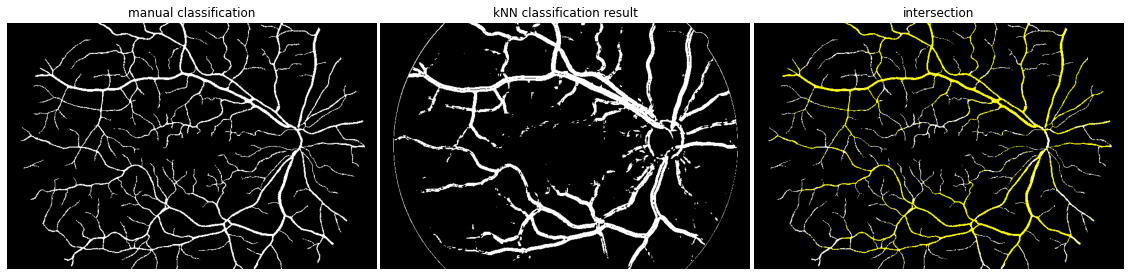

In [24]:
image = cv.imread('data/all/images/' + file_number + '_h.JPG')
mask = cv.imread('data/all/manual1/' + file_number + '_h.tif')
cut = cv.imread('data/all/mask/' + file_number + '_h_mask.tif')
predicted_image_to_display = image_pred.reshape((464, 697)).astype('uint8')
cut = cv.cvtColor(cut, cv.COLOR_BGR2GRAY)
mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
cut = cv.resize(cut, (predicted_image_to_display.shape[1], predicted_image_to_display.shape[0]))
mask = cv.resize(mask, (predicted_image_to_display.shape[1], predicted_image_to_display.shape[0]))
inversed_image = predicted_image_to_display.copy()
inversed_image[cut == 0] = 1
inversed_image = cv.bitwise_not(inversed_image)
inversed_image = (inversed_image - np.min(inversed_image)) / (np.max(inversed_image) - np.min(inversed_image))

predicted = (inversed_image == 1.0)
truth = (mask == 255)
true_positive = (predicted & truth)

yellow_mask = np.zeros((*cut.shape, 3))
yellow_mask[truth, :] = 255
yellow_mask[true_positive] = [127, 127, 0]

inversed_image = img_as_bool(inversed_image)
mask = img_as_bool(mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.01, hspace=0.1)
fig.set_size_inches(20, 12)
ax1.imshow(mask, cmap = 'gray')
ax1.set_title('manual classification')
ax2.imshow(inversed_image, cmap = 'gray')
ax2.set_title('kNN classification result')
ax3.imshow(yellow_mask)
ax3.set_title('intersection')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
fig.savefig('report/ML/' + file_number + '_h.png')

In [20]:
# depends a lot on neighbours number
TN, FP, FN, TP = confusion_matrix(mask.flatten(), inversed_image.flatten()).ravel()
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
geometric_mean = math.sqrt(specificity * sensitivity)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)
print(f'geometric mean: ', geometric_mean)

accuracy: 0.8778818087369514
sensitivity :  0.7503969887666883
specificity:  0.8928618323301152
geometric mean:  0.8185357844133793


In [36]:
from machine_learning import get_metrics
df = get_metrics(['01', '04', '12', '09', '15'])

c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\strze\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


## Deep neural network

In [25]:
from tensorflow.keras.layers import Input, Concatenate, Conv2DTranspose, MaxPool2D, Activation, BatchNormalization, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


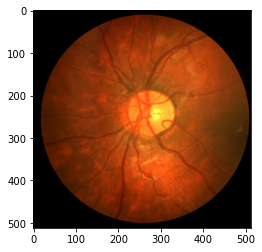

In [26]:
image = cv.imread('data/cnn/CHASEDB1/Image_01L.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = image[:, :image.shape[0]]
image = cv.resize(image, (512, 512))
imshow(image)

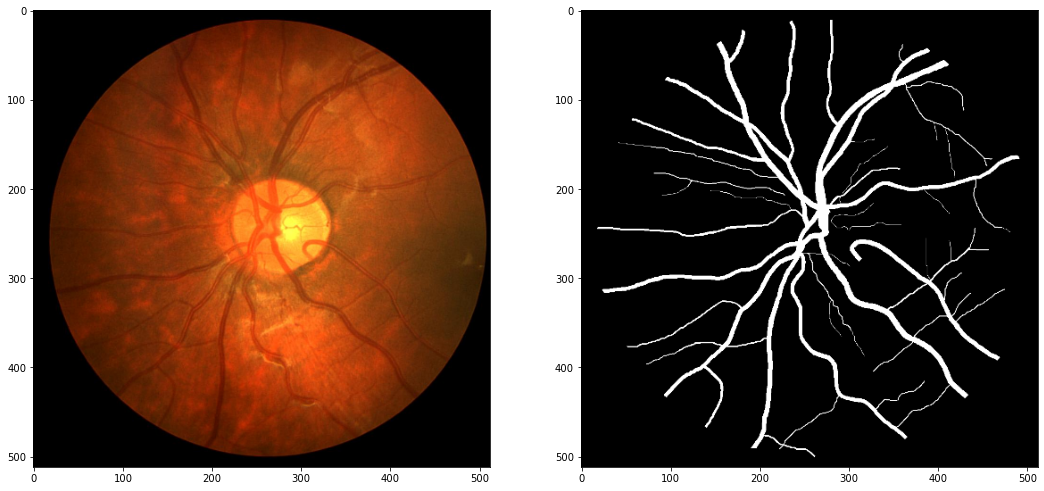

In [27]:
train_set = []
ground_truths = []
for i in range(1, 10):
    image = cv.imread('data/cnn/CHASEDB1/Image_' + str(i).zfill(2) + 'L.jpg')
    mask = cv.imread('data/cnn/CHASEDB1/Image_' + str(i).zfill(2) + 'L_1stHO.png', cv.IMREAD_GRAYSCALE)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = image[:, :image.shape[0]]
    image = cv.resize(image, (512, 512))
    mask = mask[:, :mask.shape[0]]
    mask = cv.resize(mask, (512, 512))
    image = image / 255.0
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    train_set.append(image.astype(np.float32))
    ground_truths.append(mask.astype(np.float32))

train_set = np.asarray(train_set)
ground_truths = np.asarray(ground_truths)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 12)
ax1.imshow(train_set[0])
ax2.imshow(ground_truths[0], cmap = 'gray')

cnn_image_shape = train_set[0].shape

In [28]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model
    


In [29]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
cnn = build_unet(cnn_image_shape)
cnn.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train_set, ground_truths, test_size = 0.25, random_state = 0)
model_checkpoint_callback = [
    ModelCheckpoint('checkpoint.h5', verbose = 1, save_best_only = True),
    ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 5, min_lr = 1e-6, verbose = 1),
    CSVLogger('train_logger.csv'),
    TensorBoard(),
    EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = False)
]


In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(2)
train_dataset = train_dataset.prefetch(4)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(2)
test_dataset = test_dataset.prefetch(4)

train_steps = len(X_train)//2
test_steps = len(X_test)//2

train_steps += len(X_train)%2
test_steps += len(X_test)%2



In [37]:
cnn.compile(
    loss=dice_loss,
    optimizer=Adam(learning_rate=0.001),
    metrics=[dice_coef, iou, Recall(), Precision()]
)

In [38]:
cnn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=40,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=model_checkpoint_callback
)
cnn.save('CNN')

Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 0.7185 - dice_coef: 0.2815 - iou: 0.1640 - recall_1: 0.7048 - precision_1: 0.2736 
Epoch 1: val_loss improved from inf to 0.85429, saving model to checkpoint.h5
3/3 [==============================] - 113s 39s/step - loss: 0.7185 - dice_coef: 0.2815 - iou: 0.1640 - recall_1: 0.7048 - precision_1: 0.2736 - val_loss: 0.8543 - val_dice_coef: 0.1485 - val_iou: 0.0803 - val_recall_1: 1.0000 - val_precision_1: 0.0955 - lr: 0.0010
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 0.6762 - dice_coef: 0.3238 - iou: 0.1940 - recall_1: 0.7231 - precision_1: 0.3257 
Epoch 2: val_loss did not improve from 0.85429
3/3 [==============================] - 105s 37s/step - loss: 0.6762 - dice_coef: 0.3238 - iou: 0.1940 - recall_1: 0.7231 - precision_1: 0.3257 - val_loss: 0.8558 - val_dice_coef: 0.1470 - val_iou: 0.0793 - val_recall_1: 1.0000 - val_precision_1: 0.0952 - lr: 0.0010
Epoch 3/40
3/3 [=============================

In [88]:
x = cnn.predict(train_set[:1])

0.3227374


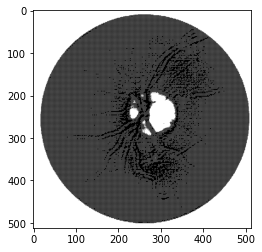

In [97]:
y = x[0]
y = y.reshape((512, 512))
print(np.max(y))
y = y > 0.06
imshow(y, cmap='gray')